# How to use filter and local_plot methods

<b>This tutorial </b>presents the different parameters you can<br />
use to summarize and display local explanations. <br />
It also shows how to export this summary into pandas DataFrame

Contents:
- Work with filter and local_plot method to tune output
- display Positive or Negative contributions
- mask hidden contrib or prediction
- hide some specific features
- Use query parameter to select without index or row number
- <b>Classification:</b> How can you select the label value to display?
- print the summary params
- export local explanation with to_pandas

Data from Kaggle [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import pandas as pd
from category_encoders import OrdinalEncoder
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split

## Building Supervized Model 

In [2]:
from shapash.data.data_loader import data_loading
house_df, house_dict = data_loading('house_prices')
y_df=house_df['SalePrice'].to_frame()
X_df=house_df[house_df.columns.difference(['SalePrice'])]

In [3]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

In [4]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=1)

In [5]:
regressor = CatBoostRegressor(n_estimators=50).fit(Xtrain,ytrain,verbose=False)

In [6]:
y_pred = pd.DataFrame(regressor.predict(Xtest),columns=['pred'],index=Xtest.index)

## Work With filter and local_plot methods

#### First step: You need to Declare and Compile SmartExplainer 

In [7]:
from shapash import SmartExplainer

In [8]:
xpl = SmartExplainer(
    model=regressor,
    preprocessing=encoder, # Optional: compile step can use inverse_transform method
    features_dict=house_dict, # Optional parameter, dict specifies label for features name 
) 

In [9]:
xpl.compile(
    x=Xtest,
    y_pred=y_pred # Optional
)

Backend: Shap TreeExplainer


#### Filter method
Use the filter method to specify how to summarize local explainability <br />
you have 4 parameters to customize your summary: <br />
- max_contrib : maximum number of criteria to display
- threshold : minimum value of the contribution (in absolute value) necessary to display a criterion
- positive : display only positive contribution? Negative?(default None)
- features_to_hide : list of features you don't want to display

In [10]:
xpl.filter(max_contrib=5)

#### Local_plot

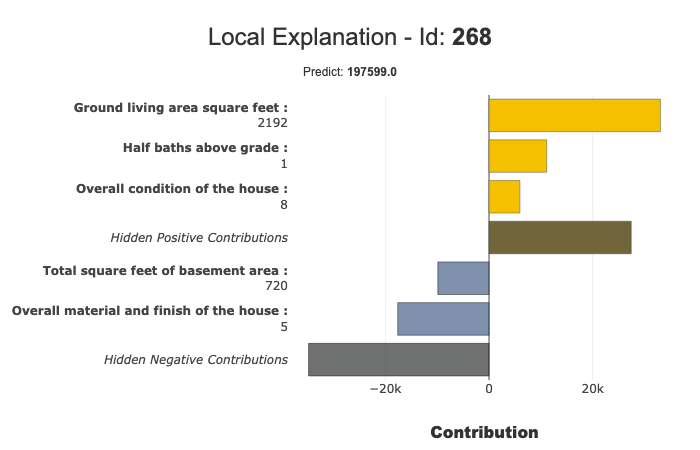

In [11]:
xpl.plot.local_plot(index=268)

#### Threshold parameter to focus on significant contributions

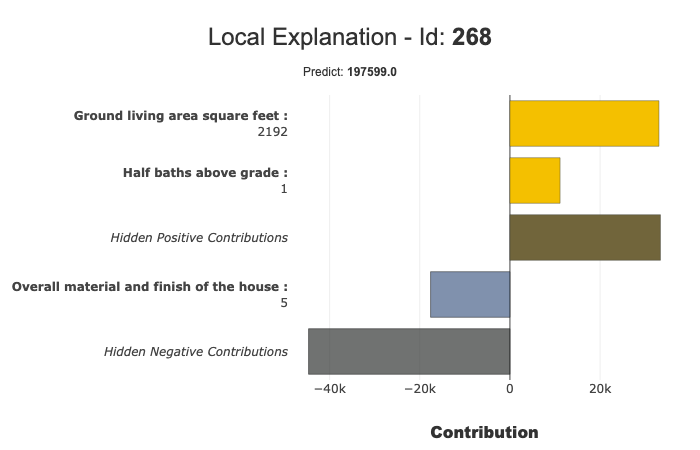

In [12]:
xpl.filter(max_contrib=5,threshold=10000)
xpl.plot.local_plot(index=268)

#### Don't display hidden contributions

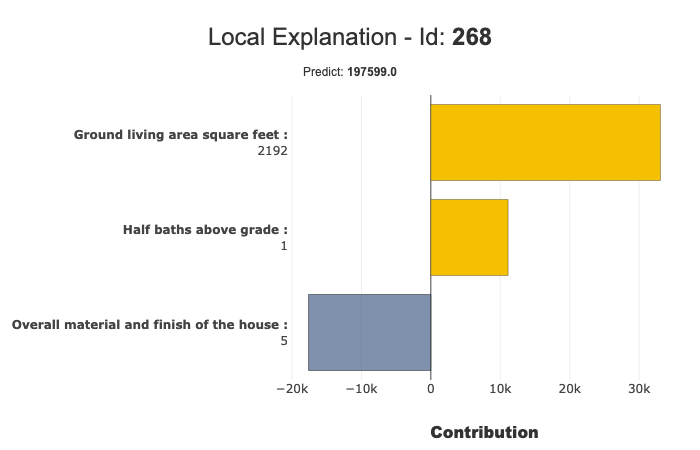

In [13]:
xpl.plot.local_plot(index=268,show_masked=False)

You can also hide the predict value with parameter show_predict=False

#### Focus on Negative contribution

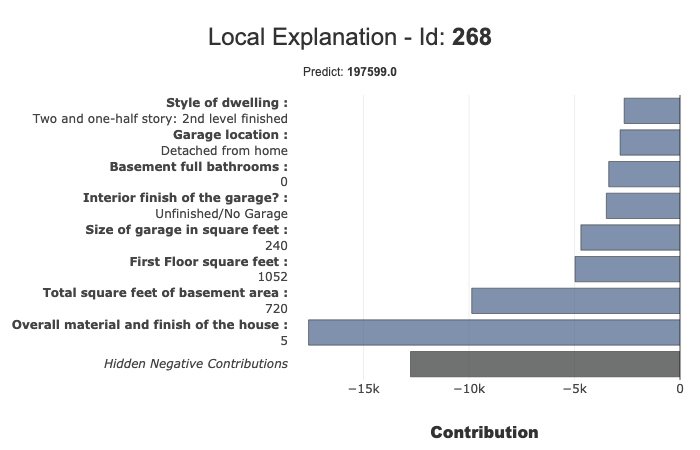

In [14]:
xpl.filter(max_contrib=8,positive=False)
xpl.plot.local_plot(index=268)

You can also focus positive contribution using positive=True

#### Hide specific features:
Because:
- some features can be too complex
- end user don't want know unnecessary information <br />

You can use features_to_hide parameter in filter method

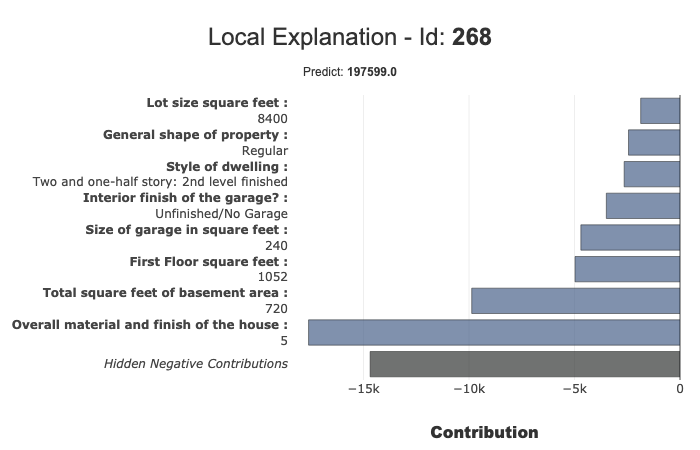

In [15]:
xpl.filter(max_contrib=8,positive=False,features_to_hide=['BsmtFullBath','GarageType'])
xpl.plot.local_plot(index=268)

#### Select a row with a query

You can selct with an index or a row number. You can also use a query:

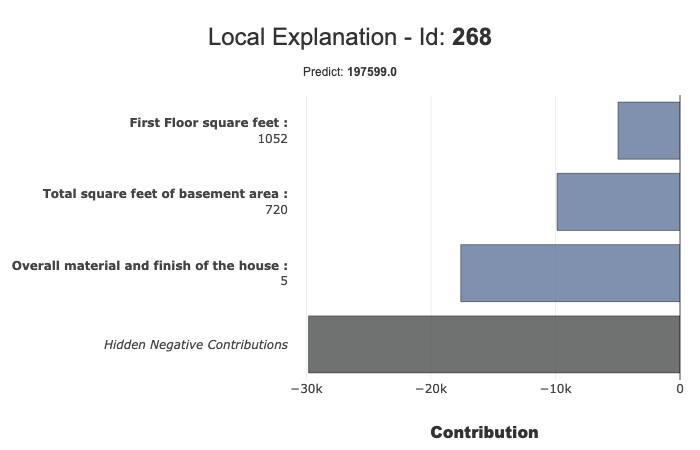

In [16]:
xpl.filter(max_contrib=3,positive=False)
xpl.plot.local_plot(query="LotArea == 8400 and LotShape == 'Regular' and TotalBsmtSF == 720")

## Classification Case

transform our use case into classification:

In [17]:
ytrain['PriceClass'] = ytrain['SalePrice'].apply(lambda x: 1 if x < 150000 else (3 if x > 300000 else 2))
label_dict = { 1 : 'Cheap', 2 : 'Moderately Expensive', 3 : 'Expensive' }

In [18]:
clf = CatBoostClassifier(n_estimators=50).fit(Xtrain,ytrain['PriceClass'],verbose=False)
y_pred_clf = pd.DataFrame(clf.predict(Xtest),columns=['pred'],index=Xtest.index)

#### Declare new SmartExplainer dedicated to classification problem 

In [19]:
xplclf = SmartExplainer(
    model=clf,
    preprocessing=encoder,
    features_dict=house_dict, 
    label_dict=label_dict # Optional parameters: display explicit output
)

In [20]:
xplclf.compile(
    x=Xtest,
    y_pred=y_pred_clf
)

Backend: Shap TreeExplainer


#### Use label parameter of local_plot parameter to select the explanation you want

with label parameter, you can specify explicit label or label number 

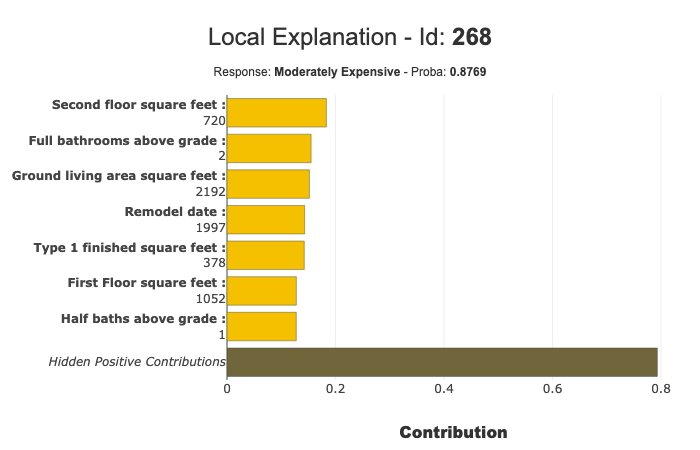

In [21]:
xplclf.filter(max_contrib=7,positive=True)
xplclf.plot.local_plot(index=268,label='Moderately Expensive')

#### See the summary parameters

In [22]:
xplclf.mask_params

{'features_to_hide': None,
 'threshold': None,
 'positive': True,
 'max_contrib': 7}

## Export explanations

#### Export your local explanation in pd.DataFrame with to_pandas method :

- The to_pandas method has the same parameters as the filter method <br />
- if you don't specify any parameter, to_pandas use the same params you specified when you call filter method<br />
- When you work on classification problem, parameter proba=True output predict probability

In [23]:
summary_df= xplclf.to_pandas(proba=True)

to_pandas params: {'features_to_hide': None, 'threshold': None, 'positive': True, 'max_contrib': 7}


In [24]:
summary_df.head()

,pred,proba,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,...,contribution_4,feature_5,value_5,contribution_5,feature_6,value_6,contribution_6,feature_7,value_7,contribution_7
259,Moderately Expensive,0.994917,Ground living area square feet,1792,0.309308,Interior finish of the garage?,Rough Finished,0.275467,Size of garage in square feet,564,...,0.182722,Physical locations within Ames city limits,College Creek,0.170888,Overall material and finish of the house,7,0.164045,Height of the basement,Good (90-99 inches),0.139618
268,Moderately Expensive,0.876916,Second floor square feet,720,0.183251,Full bathrooms above grade,2,0.155086,Ground living area square feet,2192,...,0.143119,Type 1 finished square feet,378,0.142439,First Floor square feet,1052,0.127817,Half baths above grade,1,0.127717
289,Cheap,0.997304,Ground living area square feet,900,0.818922,Size of garage in square feet,280,0.561631,Total square feet of basement area,882,...,0.349033,Full bathrooms above grade,1,0.324806,Overall material and finish of the house,5,0.318031,First Floor square feet,900,0.247826
650,Cheap,0.998653,Ground living area square feet,630,0.816398,Size of garage in square feet,0,0.587745,Total square feet of basement area,630,...,0.355685,Overall material and finish of the house,4,0.317549,Full bathrooms above grade,1,0.31303,General zoning classification,Residential Medium Density,0.178395
1234,Cheap,0.852389,Ground living area square feet,1188,0.942118,Remodel date,1959,0.423368,Overall material and finish of the house,5,...,0.373812,Number of fireplaces,0,0.168725,Rating of basement finished area,Average Rec Room,0.130175,Wood deck area in square feet,0,0.12249


It is also possible to calculate the probability relating to one of the target modality for all the dataset, and to display the elements of explainability associated with this target modality

In [25]:
#Create One column pd.DataFrame with constant value
constantpred=pd.DataFrame([3 for x in range(Xtest.shape[0])],columns=['pred'],index=Xtest.index)
xplclf.add(y_pred=constantpred)
summary_df = xplclf.to_pandas(proba=True,max_contrib=3,threshold=0.1,positive=True)

In [26]:
summary_df.head()

,pred,proba,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3
259,Expensive,0.003081,Ground living area square feet,1792,0.327986,Overall material and finish of the house,7,0.197494,Rating of basement finished area,Good Living Quarters,0.181953
268,Expensive,0.007627,Ground living area square feet,2192,0.825571,Wood deck area in square feet,262,0.251474,Remodel date,1997,0.157067
289,Expensive,0.000024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
650,Expensive,0.000056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,Expensive,0.000623,Type of sale,Court Officer Deed/Estate,0.114506,NaN,NaN,NaN,NaN,NaN,NaN


NB: The to_pandas method returns Nan for lines that do not meet your conditions